### Modul Import

In [16]:
import os
import random
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import librosa.display
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from sklearn import preprocessing

from audiomentations import Compose, AddGaussianNoise, PitchShift, AddBackgroundNoise, PolarityInversion
from IPython.display import display, Audio, HTML
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D,  Flatten, Dropout
warnings.filterwarnings("ignore")

### Variable Declare

In [17]:
SAMPLE_RATE = 22050
FRAME_SIZE = 1024
DURATION = int(4 * SAMPLE_RATE)
HOP_SIZE = int(DURATION * 0.5)

### Path & Emotion Extraction

In [4]:
tess_path = './Dataset/TESS/'
asvp_path = './Dataset/asvp/Audio'
ravdess_path = './Dataset/RavDess/'

In [5]:
tess_df = pd.DataFrame(columns=['path', 'label'])
for folder in os.listdir(os.path.join('Dataset', 'TESS')):
    for file in os.listdir(os.path.join('Dataset', 'TESS', folder)):
        path = os.path.join('Dataset', 'TESS', folder, file)
        label = file.split('.')[0].split('_')[-1]
        tess_df = pd.concat([tess_df, pd.DataFrame({'path':[path], 'label':[label]})], ignore_index=1)

In [6]:
asvp_df = pd.DataFrame(columns=['path', 'label'])
for folder in os.listdir(asvp_path):
    for file in os.listdir(os.path.join(asvp_path, folder)):
        path = os.path.join(asvp_path, folder, file)
        try:
            if file.split('-')[1] == '01' and file.split('-')[-2] == '02' and len(file.split('-')) == 9:
                emotion = file.split('-')[2]
                asvp_df = pd.concat([asvp_df, pd.DataFrame({'path':[path], 'label': [emotion]})], ignore_index=1)
        except:
            print(file)

asvp_df.label.replace({'01': 'boredom', '02': 'neutral','03': 'happy', '04': 'sad', '05': 'angry', '06': 'fear', '07': 'disgust', '08': 'surprised', '09': 'excited',
                                                '10': 'pleasure', '11': 'pain', '12': 'disappointmen'}, inplace=True)

In [7]:
ravdess_df = pd.DataFrame(columns=['path', 'label'])
for folder in os.listdir(ravdess_path):
    for file in os.listdir(os.path.join(ravdess_path, folder)):
        path = os.path.join(ravdess_path, folder, file)
        if file.split('-')[0] == '03':
            emotion = file.split('-')[2]
            ravdess_df = pd.concat([ravdess_df, pd.DataFrame({'path':[path], 'label': [emotion]})], ignore_index=1)
ravdess_df.label.replace({'01': 'neutral', '02': 'neutral', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fear', '07': 'disgust', '08': 'surprised'}, inplace=True)

In [8]:
tess_df['duration'] = tess_df['path'].apply(lambda x: librosa.get_duration(filename=x))
asvp_df['duration'] = asvp_df['path'].apply(lambda x: librosa.get_duration(filename=x))
ravdess_df['duration'] = ravdess_df['path'].apply(lambda x: librosa.get_duration(filename=x))

In [9]:
combined_df = pd.concat([tess_df, asvp_df, ravdess_df])

In [10]:
combined_df.to_csv('combined.csv', index=False)

### Pre-Processing

In [2]:
combined_df = pd.read_csv('combined.csv')

In [3]:
combined_df

,path,label,duration
0,Dataset\TESS\OAF_angry\OAF_back_angry.wav,angry,1.539035
1,Dataset\TESS\OAF_angry\OAF_bar_angry.wav,angry,1.616613
2,Dataset\TESS\OAF_angry\OAF_base_angry.wav,angry,1.542025
3,Dataset\TESS\OAF_angry\OAF_bath_angry.wav,angry,1.606865
4,Dataset\TESS\OAF_angry\OAF_bean_angry.wav,angry,1.395183
...,...,...,...
4684,./Dataset/RavDess/Actor_24\03-01-08-01-02-02-2...,surprised,3.403396
4685,./Dataset/RavDess/Actor_24\03-01-08-02-01-01-2...,surprised,3.937271
4686,./Dataset/RavDess/Actor_24\03-01-08-02-01-02-2...,surprised,3.970625
4687,./Dataset/RavDess/Actor_24\03-01-08-02-02-01-2...,surprised,3.670333


In [4]:
combined_df.isnull().sum()

path        0
label       0
duration    0
dtype: int64

In [5]:
combined_df['label'].unique()

array(['angry', 'disgust', 'fear', 'happy', 'sad', 'neutral', 'surprised',
       'excited', 'disappointmen', 'pleasure', 'boredom', 'pain'],
      dtype=object)

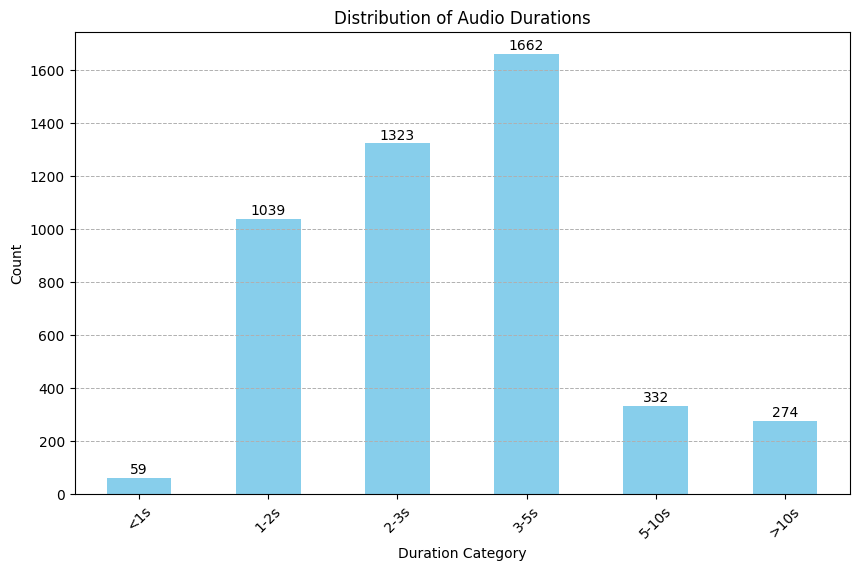

In [6]:
bins = [0, 1, 2, 3, 5, 10, float('inf')]
labels = ['<1s', '1-2s', '2-3s', '3-5s', '5-10s', '>10s']
combined_df['duration_category'] = pd.cut(combined_df['duration'], bins=bins, labels=labels, right=False)

duration_counts = combined_df['duration_category'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
ax = duration_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Duration Category')
plt.ylabel('Count')
plt.title('Distribution of Audio Durations')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)

for index, value in enumerate(duration_counts):
    plt.text(index, value + 5, str(value), ha='center', va='bottom')

plt.show()

In [7]:
combined_df.describe()

,duration
count,4689.000000
mean,3.663141
std,2.947372
min,0.275375
25%,2.033178
50%,2.719438
75%,3.803812
max,29.977000


In [8]:
def plot_df(df):
    label_counts = df.value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=label_counts.index, y=label_counts.values, width=0.8, color='skyblue')
    plt.xlabel("Emotion")
    plt.ylabel("Count")

    for index, value in enumerate(label_counts.values):
        plt.text(index, value + 1, str(value), ha='center', va='bottom')
    plt.show()

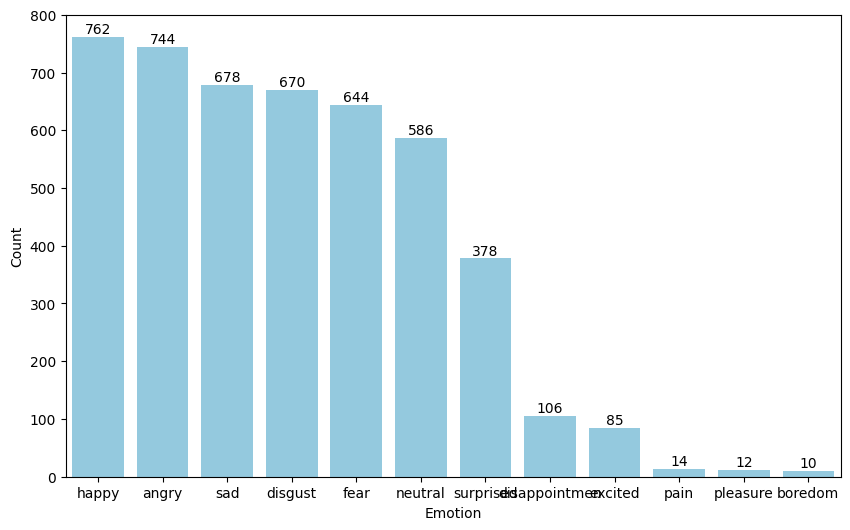

In [9]:
plot_df(combined_df['label'])

In [10]:
selected_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'neutral', 'surprised']
combined_df = combined_df[combined_df['label'].isin(selected_labels)]

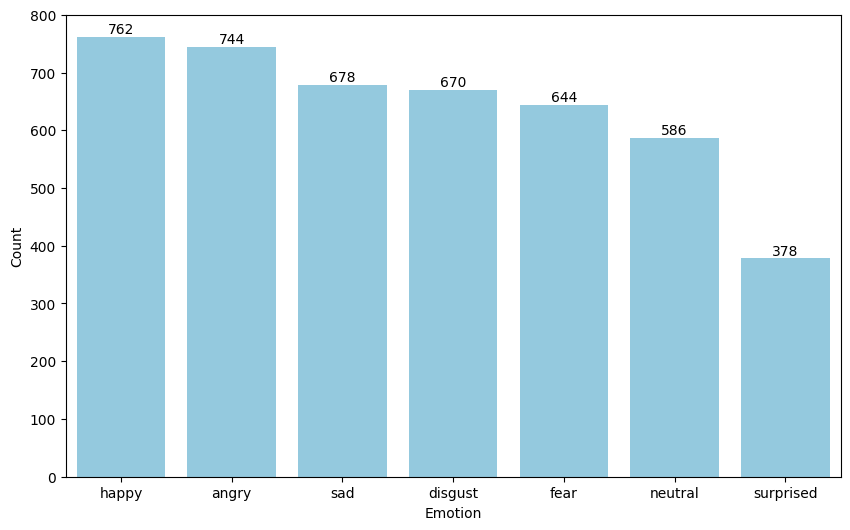

In [11]:
plot_df(combined_df['label'])

In [18]:
def wave_audio(df, label = 'label'):
    emotion = df[label].unique()
    n_rows = 2
    n_cols = 4
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5))
    fig.tight_layout(h_pad=4)
    
    audio_html = ""
    for i, x in enumerate(emotion):
        row = i // n_cols
        col = i % n_cols
        path = df.loc[df[label] == x, 'path'].values[random.randint(1, 378)]
        dat, sr = librosa.load(path)
        ax[row, col].set_title(x)
        librosa.display.waveshow(dat, sr=SAMPLE_RATE, ax=ax[row, col])
        
        audio_html += f"<div style='display: inline-block; width: 30%; margin: 10px;'><p>{x}</p>{Audio(path)._repr_html_()}</div>"
    
    display(HTML(f"<div style='display: flex; flex-wrap: wrap;'>{audio_html}</div>"))
    
    plt.subplots_adjust(hspace=0.4)
    plt.show()

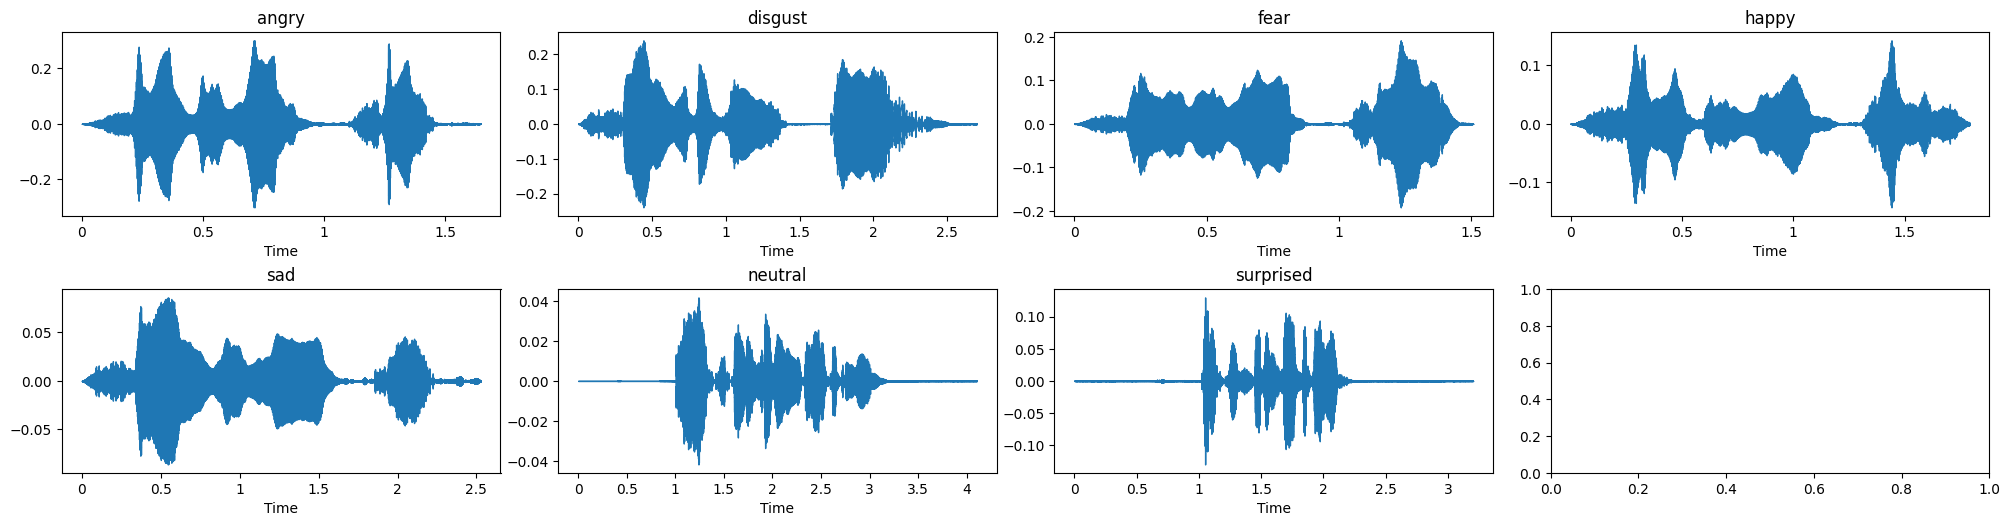

In [19]:
wave_audio(combined_df)

### Processing

In [20]:
label_encoder = preprocessing.LabelEncoder()

In [21]:
combined_df['label'].unique()

array(['angry', 'disgust', 'fear', 'happy', 'sad', 'neutral', 'surprised'],
      dtype=object)

In [22]:
combined_df['label_enc'] = label_encoder.fit_transform(combined_df['label'])

In [23]:
label_encoder.fit_transform(['angry', 'disgust', 'fear', 'happy', 'sad', 'neutral', 'surprised'])

array([0, 1, 2, 3, 5, 4, 6], dtype=int64)

In [24]:
np.save('./saved_model/label_classes_7.npy', label_encoder.classes_)

In [25]:
combined_df

,path,label,duration,duration_category,label_enc
0,Dataset\TESS\OAF_angry\OAF_back_angry.wav,angry,1.539035,1-2s,0
1,Dataset\TESS\OAF_angry\OAF_bar_angry.wav,angry,1.616613,1-2s,0
2,Dataset\TESS\OAF_angry\OAF_base_angry.wav,angry,1.542025,1-2s,0
3,Dataset\TESS\OAF_angry\OAF_bath_angry.wav,angry,1.606865,1-2s,0
4,Dataset\TESS\OAF_angry\OAF_bean_angry.wav,angry,1.395183,1-2s,0
...,...,...,...,...,...
4684,./Dataset/RavDess/Actor_24\03-01-08-01-02-02-2...,surprised,3.403396,3-5s,6
4685,./Dataset/RavDess/Actor_24\03-01-08-02-01-01-2...,surprised,3.937271,3-5s,6
4686,./Dataset/RavDess/Actor_24\03-01-08-02-01-02-2...,surprised,3.970625,3-5s,6
4687,./Dataset/RavDess/Actor_24\03-01-08-02-02-01-2...,surprised,3.670333,3-5s,6


In [26]:
def extract_features(path):
    signal, _ = librosa.load(path, sr=SAMPLE_RATE)
    return signal

In [27]:
combined_df['signal'] = combined_df['path'].apply(lambda x: extract_features(x))

In [28]:
combined_df

,path,label,duration,duration_category,label_enc,signal
0,Dataset\TESS\OAF_angry\OAF_back_angry.wav,angry,1.539035,1-2s,0,"[-1.1267163e-05, -0.00019048303, -0.0002863420..."
1,Dataset\TESS\OAF_angry\OAF_bar_angry.wav,angry,1.616613,1-2s,0,"[-7.194043e-06, -8.9411995e-05, -0.00010512397..."
2,Dataset\TESS\OAF_angry\OAF_base_angry.wav,angry,1.542025,1-2s,0,"[-4.4029694e-06, 4.350982e-05, 4.4699904e-05, ..."
3,Dataset\TESS\OAF_angry\OAF_bath_angry.wav,angry,1.606865,1-2s,0,"[7.3401234e-06, -0.00018113297, -9.732881e-05,..."
4,Dataset\TESS\OAF_angry\OAF_bean_angry.wav,angry,1.395183,1-2s,0,"[-1.5064217e-05, -8.110988e-06, -9.182017e-05,..."
...,...,...,...,...,...,...
4684,./Dataset/RavDess/Actor_24\03-01-08-01-02-02-2...,surprised,3.403396,3-5s,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4685,./Dataset/RavDess/Actor_24\03-01-08-02-01-01-2...,surprised,3.937271,3-5s,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4686,./Dataset/RavDess/Actor_24\03-01-08-02-01-02-2...,surprised,3.970625,3-5s,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4687,./Dataset/RavDess/Actor_24\03-01-08-02-02-01-2...,surprised,3.670333,3-5s,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [29]:
combined_df = combined_df[['signal', 'label_enc']]

In [30]:
def segment(signal):
    frame_size = DURATION
    hop_length = HOP_SIZE
    total_samples = len(signal)

    segments = []

    for start in range(0, total_samples, hop_length):
        end = start + frame_size
        if end > total_samples:
            segment = np.pad(signal[start:total_samples], (0, end - total_samples), 'constant')
        else:
            segment = signal[start:end]
        segments.append(segment)
    
    return segments

In [31]:
def segment_to_df(df):
    new_df = pd.DataFrame()

    for i, row in df.iterrows():
        segments = segment(row['signal'])
        label = row['label_enc']
        for j, x in enumerate(segments):
            new_df = pd.concat([new_df, pd.DataFrame({'signal':[x], 'label':[label]})], ignore_index=1)

    return new_df

In [32]:
combined_df = segment_to_df(combined_df)

In [33]:
X, X_val, y, y_val = train_test_split(combined_df['signal'], combined_df['label'], test_size=0.10, random_state=40, stratify=combined_df['label'])

In [34]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.50, random_state=40, stratify=y_val)

In [35]:
train_df = pd.concat([X, y], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [36]:
train_df['label'].value_counts()

label
0    1547
4    1527
3    1457
5    1442
1    1287
2     834
6     726
Name: count, dtype: int64

In [37]:
val_df['label'].value_counts()

label
0    86
4    85
3    81
5    80
1    71
2    46
6    41
Name: count, dtype: int64

In [38]:
test_df['label'].value_counts()

label
0    86
4    85
3    81
5    80
1    72
2    47
6    40
Name: count, dtype: int64

### Data Augmentation

In [39]:
augment = Compose([
  AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.0055, p=1),
  PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
  AddBackgroundNoise('./Noise/crowdy.mp3', noise_transform=PolarityInversion(), p=1)
])

In [40]:
def augment_audio(signal, sr):
    aug_signal = augment(signal, sr)
    return aug_signal

In [41]:
def augment_df(df):
    X = pd.DataFrame()
    for i, row in df.iterrows():
        signal = row['signal']
        label = row['label']
        new_row = pd.DataFrame({'signal': [signal], 'label': [label], 'augmented': ['No']})
        X = pd.concat([X, new_row], ignore_index=True)
        for j in range(0, 2):
            aug_signal = augment_audio(signal, SAMPLE_RATE)
            new_row = pd.DataFrame({'signal': [aug_signal], 'label': [label], 'augmented': ['Yes']})
            X = pd.concat([X, new_row], ignore_index=True)
    return X

In [42]:
train_df = augment_df(train_df)

In [43]:
del X, X_test, X_val, y, y_test, y_val, combined_df

In [44]:
train_df.shape

(26460, 3)

### Feature Extraction

In [75]:
def extract_features(data):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=SAMPLE_RATE, n_mfcc=20, n_fft=FRAME_SIZE, hop_length=(FRAME_SIZE//2)), axis=1)
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=SAMPLE_RATE, n_mels=20, n_fft=FRAME_SIZE, hop_length=(FRAME_SIZE//2)), axis=1)
    spec_con = np.mean(librosa.feature.spectral_contrast(y=data, sr=SAMPLE_RATE, n_fft=FRAME_SIZE, hop_length=(FRAME_SIZE//2)), axis=1)
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=data, sr=SAMPLE_RATE, n_fft=FRAME_SIZE, hop_length=(FRAME_SIZE//2)), axis=1)
    result = np.hstack((mfcc, mel, spec_con, chroma_stft))
    
    return result

In [76]:
train_df

,signal,label
0,"[-0.06035309, -0.04948423, -0.03523834, -0.030...",4
1,"[-0.059881162, -0.05222195, -0.03490973, -0.03...",4
2,"[-0.044541724, -0.04075892, -0.033534847, -0.0...",4
3,"[7.2832023e-07, -7.1693904e-07, 6.867819e-07, ...",4
4,"[-0.0056186225, 0.0007935406, 0.001771525, -0....",4
...,...,...
26455,"[0.004059965, 0.007912747, 0.0074516414, 0.000...",4
26456,"[0.007941601, 0.0119983265, 0.005317108, 0.012...",4
26457,"[-0.015721366, -0.016179906, -0.012250693, -0....",4
26458,"[-0.015580321, -0.012913461, -0.010666716, -0....",4


In [77]:
train_df['extract'] = train_df['signal'].apply(lambda x: extract_features(x))

In [78]:
val_df['extract'] = val_df['signal'].apply(lambda x: extract_features(x))

In [79]:
def check_minmax(df):
    max_shape = max(df.apply(lambda x: x.shape[0]))
    min_shape = min(df.apply(lambda x: x.shape[0]))

    return min_shape, max_shape

In [80]:
min_train, max_train = check_minmax(train_df['extract'])
min_val, max_val = check_minmax(val_df['extract'])
print(f'Train:\nMin shape: {min_train}\nMax shape: {max_train}\nVal:\nMin shape: {min_train}\nMax shape: {max_train}')

Train:
Min shape: 59
Max shape: 59
Val:
Min shape: 59
Max shape: 59


In [81]:
X_train = np.stack(train_df['extract'].values)
y_train = np.stack(train_df['label'].values)

In [82]:
X_val = np.stack(val_df['extract'].values)
y_val = np.stack(val_df['label'].values)

In [83]:
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

In [84]:
X_train.shape, X_val.shape

((26460, 59, 1), (490, 59, 1))

In [98]:
model = Sequential()
model.add(Conv1D(32, 8, activation='relu', input_shape=(59, 1)))
model.add(MaxPooling1D((1)))
model.add(Conv1D(64, 8, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Dropout(0.2))
model.add(Conv1D(128, 8, activation='relu'))
model.add(MaxPooling1D((1)))
# model.add(Conv1D(256, 8, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [100]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 52, 32)            288       
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 52, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 45, 64)            16448     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 45, 64)           0         
 g1D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 45, 64)            0         
                                                                 
 conv1d_17 (Conv1D)          (None, 38, 128)          

In [101]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [102]:
hist = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data = (X_val, y_val))

Epoch 1/50
827/827 [==============================] - 4s 4ms/step - loss: 1.7166 - accuracy: 0.3193 - val_loss: 1.3471 - val_accuracy: 0.5408
Epoch 2/50
827/827 [==============================] - 3s 4ms/step - loss: 1.4772 - accuracy: 0.4412 - val_loss: 1.1913 - val_accuracy: 0.5714
Epoch 3/50
827/827 [==============================] - 3s 3ms/step - loss: 1.3684 - accuracy: 0.4786 - val_loss: 1.0793 - val_accuracy: 0.6122
Epoch 4/50
827/827 [==============================] - 3s 4ms/step - loss: 1.2956 - accuracy: 0.5090 - val_loss: 1.0311 - val_accuracy: 0.6286
Epoch 5/50
827/827 [==============================] - 3s 4ms/step - loss: 1.2396 - accuracy: 0.5336 - val_loss: 1.0240 - val_accuracy: 0.6388
Epoch 6/50
827/827 [==============================] - 3s 4ms/step - loss: 1.1898 - accuracy: 0.5511 - val_loss: 0.9609 - val_accuracy: 0.6592
Epoch 7/50
827/827 [==============================] - 3s 4ms/step - loss: 1.1566 - accuracy: 0.5632 - val_loss: 0.9185 - val_accuracy: 0.6776
Epoch 

16/16 [==============================] - 0s 5ms/step - loss: 0.7867 - accuracy: 0.7571
Testing accuracy of our model:  75.71428418159485 %


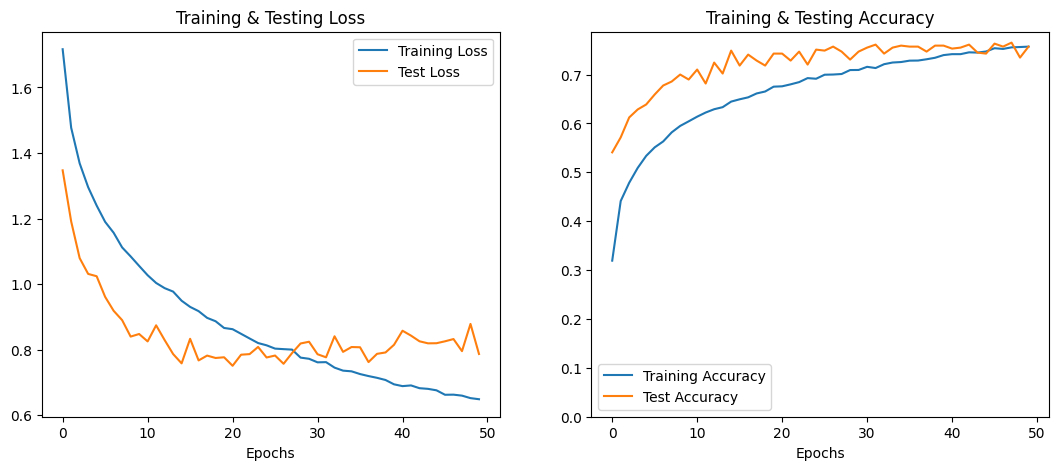

In [104]:
print('Testing accuracy of our model: ', model.evaluate(X_val, y_val)[1]*100, '%')
epochs = [i for i in range(50)]
fig, ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
test_acc = hist.history['val_accuracy']
test_loss = hist.history['val_loss']

fig.set_size_inches(13,5)
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Test Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')

ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Test Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epochs')
# plt.savefig('./saved_graph/Training and Tesing Loss & Accuracy')
plt.ylim(ymin=0)
plt.show()

In [105]:
model.save('./saved_model/Mood_7_.h5')

### Testing

In [64]:
test_df

,signal,label
4253,"[-0.00410817, -0.0030062082, -0.002855523, -0....",0
8987,"[7.0633156e-14, -1.01506565e-13, -2.7802766e-1...",4
7489,"[-7.776063e-07, -3.4015402e-06, -0.00011360683...",4
6523,"[0.14530396, 0.13639551, 0.1279496, 0.11263259...",2
8809,"[0.005765786, 0.0068769227, 0.008729118, 0.010...",1
...,...,...
6355,"[0.27634776, 0.23565221, 0.22038198, 0.1916671...",0
4420,"[-0.16115884, -0.15196724, -0.1151373, -0.0524...",0
884,"[1.1453673e-05, 8.2719285e-05, 7.016442e-05, 8...",3
1220,"[-1.8794413e-05, -0.00010893858, -0.0001005119...",5


In [65]:
test_df['extract'] = test_df['signal'].apply(lambda x: extract_features(x))

In [66]:
X_test = np.stack(test_df['extract'].values)
y_test = np.stack(test_df['label'].values)

In [67]:
X_test = X_test[..., np.newaxis]

In [68]:
X_test.shape

(491, 275, 1)

In [69]:
y_pred_enc = model.predict(X_test)
y_pred = np.argmax(y_pred_enc, axis=1)

16/16 [==============================] - 0s 13ms/step


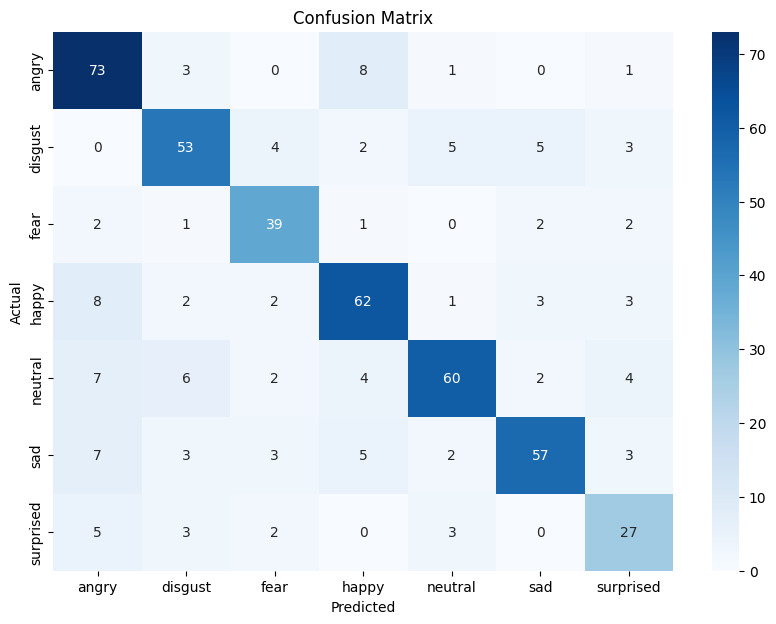

              precision    recall  f1-score   support

       angry       0.72      0.85      0.78        86
     disgust       0.75      0.74      0.74        72
        fear       0.75      0.83      0.79        47
       happy       0.76      0.77      0.76        81
     neutral       0.83      0.71      0.76        85
         sad       0.83      0.71      0.77        80
   surprised       0.63      0.68      0.65        40

    accuracy                           0.76       491
   macro avg       0.75      0.75      0.75       491
weighted avg       0.76      0.76      0.76       491



In [70]:
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Tampilkan laporan klasifikasi
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))